In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
import sys
sys.path.append('..')
from lib.etl import parse_canvas_csv
from lib.vis import plot_session_intervals
from lib.course import LECTURES, ASSIGNMENTS
from lib.sql import Lecture, Viewing, Base
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from intervaltree import IntervalTree
from tqdm.auto import tqdm

In [82]:
def add_col(self, series, name=None):
    if name is not None:
        series = series.rename(name)
    return pd.concat([self, series], axis=1)
setattr(pd.DataFrame, 'add_col', add_col)

In [83]:
def export_csv():
    pd.DataFrame([l.to_json() for l in LECTURES]).to_csv('../data/lectures.csv', index=False)
    pd.DataFrame([a.to_json() for a in ASSIGNMENTS]).to_csv('../data/assignments.csv', index=False)
    pd.DataFrame(sum([a.to_index_json() for a in ASSIGNMENTS], [])) \
        .to_csv('../data/lecture-assignments.csv', index=False)
    vd = [l.viewing_data() for l in LECTURES]
    all_vd = pd.concat(vd)
    all_vd.to_csv('../data/viewing.csv', index=False)    

In [84]:
vd = pd.concat([l.viewing_data() for l in LECTURES])

In [85]:
users = vd.user.unique()

In [86]:
dropped = []
for u in users:
    vdu = vd[vd.user == u]
    if vdu.lecture.max() < 5:
        dropped.append(u)

In [87]:
users = [u for u in users if u not in dropped]
vd = vd[vd.user.isin(users)]

In [95]:
lowview = []
for u in users:
    vdu = vd[vd.user == u]
    if vdu.sum().minutes < 100:
        lowview.append(u)

In [96]:
users = [u for u in users if u not in lowview]
vd = vd[vd.user.isin(users)]

In [116]:
vd = vd.add_col(vd.time.dt.hour, 'hour')

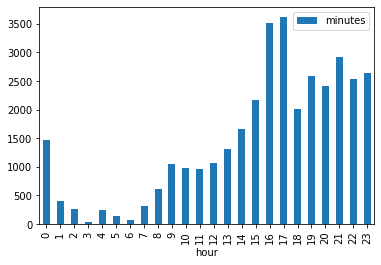

In [122]:
vd.groupby('hour').sum().plot.bar(y='minutes')

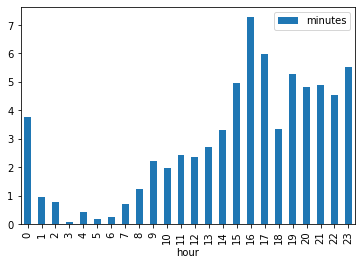

In [131]:
df = vd.groupby(['user', 'hour']).sum()
(df / df.groupby('user').sum()).groupby('hour').sum().plot.bar(y='minutes')

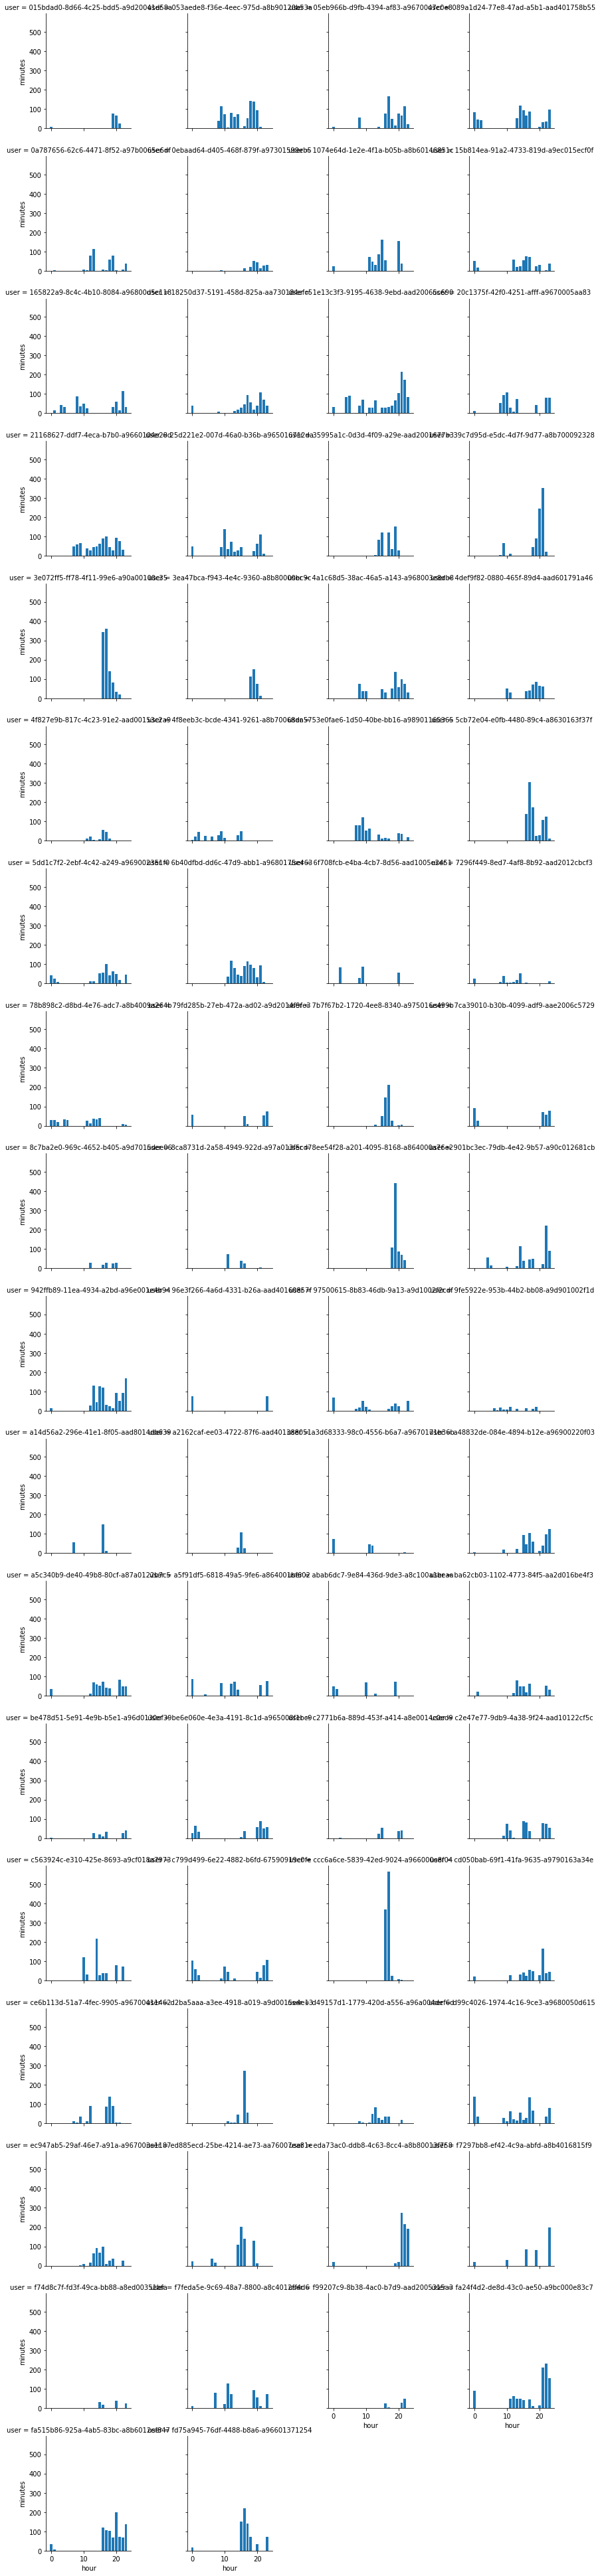

In [118]:
g = sns.FacetGrid(
    vd.groupby(['user', 'hour']).sum().reset_index(),
    col="user", col_wrap=4)

g.map(plt.bar, "hour", "minutes")

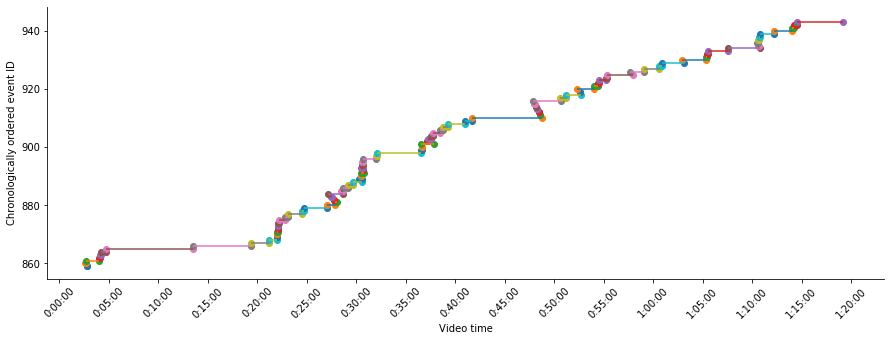

In [163]:
u = users[18]
lec_vd = vd[(vd.user == u) & (vd.lecture == 1)]
plot_session_intervals(lec_vd)

In [196]:
def coverage(lec_vd):    
    START = 60 * 5
    END = 60 * 75
    t = IntervalTree()
    for _, row in lec_vd.iterrows():
        t.addi(row.start, row.end)
    t.merge_overlaps()
    t.chop(0, START)
    if len(t) == 0:
        return 0
    t.chop(END, max([i.end for i in t]))

    return sum([i.end - i.begin for i in t]) / (END - START)

In [199]:
cov_rows = []
for u in tqdm(users):
    for lec in range(1, 14):
        lec_vd = vd[(vd.user == u) & (vd.lecture == lec)]
        cov_rows.append({
            'user': u,
            'lecture': lec,
            'coverage': coverage(lec_vd)
        })

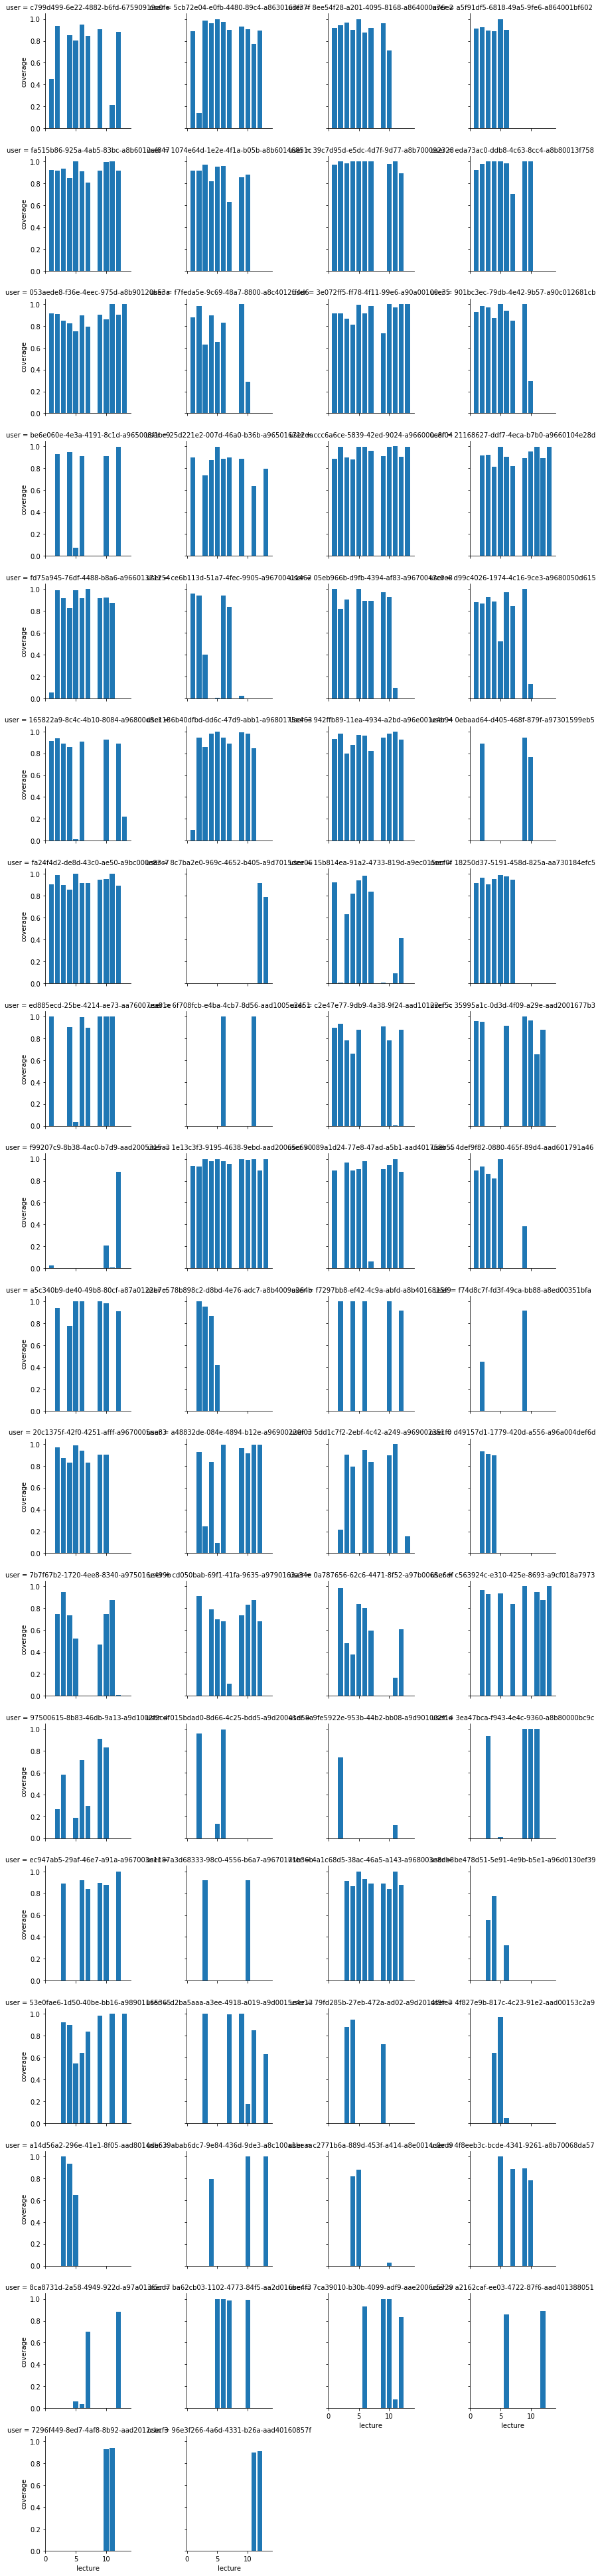

In [215]:
cov_df = pd.DataFrame(cov_rows)

order = cov_df[cov_df.coverage > 0.1].groupby('user').std().sort_values(by=['coverage'], ascending=False).index

g = sns.FacetGrid(
    cov_df,
    col="user", col_wrap=4, row_order=order)

g.map(plt.bar, "lecture", "coverage")